# Packages

In [1]:
import pandas as pd 
import numpy as np 
from functools import reduce

import warnings
import pickle
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import seaborn as sns

#Regression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

#Decomposition
from sklearn.decomposition import PCA

## Reading the data

In [2]:
xlsx = pd.read_excel('/Users/azmanizakary/Downloads/Integrated_Data_BAM.xlsx', sheet_name=None, header=0)
for sheet in xlsx.keys(): xlsx[sheet].to_excel(sheet+'.xlsx', header=True, index=True)

## Data Preprocessing

In [3]:
for key in xlsx.keys():
    print(key, ':\n', xlsx[key].isnull().sum())

unemployment_rate :
 YYMM                  0
Unenployment Rate     0
Population           10
dtype: int64
extra_unemployment_rate :
 Date                        0
Unemployment Rate           0
Unemployment (Thousands)    0
    Female                  0
    Male                    0
dtype: int64
gov_total_expense_revenue :
 YYMM                  0
Expense               0
Revenue               0
Surplus or Deficit    0
dtype: int64
money_supply :
 YYMM                  0
M1                    0
M2                    0
M2 YOY Growth Rate    0
M3                    0
M3 YOY Growth Rate    0
M4                    0
M4 YOY Growth Rate    0
dtype: int64
bonds :
 YYMM       0
5 Year     0
10 Year    0
20 Year    0
dtype: int64
cpi :
 YYMM                      0
CPI                       0
CPI Annual Growth Rate    0
dtype: int64
economic_growth :
 YYMM                        0
GBP to USD Exchange Rate    0
Economic Growth Rate        4
dtype: int64
import_export :
 YYMM      0
Import    0
Expo

In [4]:
for key in xlsx.keys():
    xlsx[key].replace('--', np.nan, inplace=True)
    print(key, ':\n', xlsx[key])

unemployment_rate :
         YYMM  Unenployment Rate  Population
0    2024/10                4.3         NaN
1    2024/09                4.3         NaN
2    2024/08                4.1         NaN
3    2024/07                4.2         NaN
4    2024/06                4.2         NaN
..       ...                ...         ...
173  2010/05                7.9       62.76
174  2010/04                8.0       62.76
175  2010/03                8.0       62.76
176  2010/02                7.9       62.76
177  2010/01                7.7       62.76

[178 rows x 3 columns]
extra_unemployment_rate :
         Date  Unemployment Rate  Unemployment (Thousands)      Female  \
0   Dec 2024                NaN                       NaN         NaN   
1   Nov 2024                4.4                    1568.0         4.2   
2   Oct 2024                4.3                    1508.0         4.0   
3   Sep 2024                4.3                    1509.0         4.1   
4   Aug 2024                4.1    

In [5]:
for key in xlsx.keys() - {'uk_home_retail'}:
    columns_to_fill = xlsx[key].columns[1:]
    
    # Calculate the median for the selected columns
    median_values = xlsx[key][columns_to_fill].median()
    
    # Fill NaN values with the median
    xlsx[key][columns_to_fill] = xlsx[key][columns_to_fill].fillna(median_values)

In [6]:
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].drop('UK Home Sales', axis=1)
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].dropna(axis=1)
xlsx['construction_cost_prices_sales'] = xlsx['construction_cost_prices_sales'].dropna()

## Time features 

In [7]:
import re

keys_q_only = [
    key for key in xlsx.keys()
    if not xlsx[key].empty  # Vérifie que le DataFrame n'est pas vide
    and xlsx[key].shape[1] > 0  # Vérifie qu'il a au moins une colonne
    and xlsx[key][xlsx[key].columns[0]].astype(str)  # Convertit en str
        .str.match(r'^Q', na=False)  # Vérifie que toutes les valeurs commencent par "Q"
        .all()  # S'assure que c'est vrai pour toute la colonne
]

In [8]:
for key in xlsx.keys() - set(keys_q_only):
    xlsx[key][xlsx[key].columns[0]] = pd.to_datetime(xlsx[key][xlsx[key].columns[0]], errors='coerce')
    
for key in keys_q_only:
    # Extraction du Quarter et de l'Année
    xlsx[key][xlsx[key].columns[0]] = pd.to_datetime(xlsx[key][xlsx[key].columns[0]].str[-4:] + xlsx[key][xlsx[key].columns[0]].str[:2])

In [9]:
def to_snake_case(col_name):
    col_name = re.sub(r'([a-z])([A-Z])', r'\1_\2', col_name)  # Convert camelCase/PascalCase to snake_case
    col_name = re.sub(r'\W+', '_', col_name)  # Replace non-word characters (spaces, special chars) with "_"
    col_name = re.sub(r'__+', '_', col_name)  # Replace multiple "_" with a single "_"
    return col_name.lower().strip('_')  # Convert to lowercase and remove leading/trailing "_"

In [10]:
for key in xlsx.keys():
    xlsx[key].columns = [to_snake_case(xlsx[key].columns[0])] + [f"{key}.{to_snake_case(col)}" for col in xlsx[key].columns[1:]]
    xlsx[key] = xlsx[key].rename(columns={'yymm': 'date', 'revenues': 'date'})

In [11]:
#drop duplicated time samples
xlsx['uk_home_retail'] = xlsx['uk_home_retail'].sort_values('date', ascending=False).drop_duplicates('date').sort_index()

In [12]:
for key in xlsx.keys():
    xlsx[key] = xlsx[key].sort_values('date', ascending=False)

## Merging the data into one dataset

In [13]:
def reformat_trimestrielle(df):
    df_expanded = pd.DataFrame()
    for _, row in df.iterrows():
        # Créer 3 mois à partir de la date du trimestre
        months = pd.date_range(start=row['date'], periods=3, freq='ME')
        expanded = pd.DataFrame([row.to_dict()] * 3)
        expanded['date'] = months
        df_expanded = pd.concat([df_expanded, expanded], ignore_index=True)
    return df_expanded

def reformat_annuelle(df):
    df_expanded = pd.DataFrame()
    for _, row in df.iterrows():
        # Créer 12 mois à partir de la date annuelle
        months = pd.date_range(start=row['date'], periods=12, freq='ME')
        expanded = pd.DataFrame([row.to_dict()] * 12)
        expanded['date'] = months
        df_expanded = pd.concat([df_expanded, expanded], ignore_index=True)
    return df_expanded

In [14]:
def process_data(xlsx):
    result = pd.DataFrame()
    data_frames = []
    for sheet_name, df in xlsx.items():

        # Identifier la granularité des données
        freq = pd.infer_freq(df['date'].sort_values())

        if 'Y' in freq:  # Données annuelles
            df_processed = reformat_annuelle(df)
        elif 'Q' in freq:  # Données trimestrielles
            df_processed = reformat_trimestrielle(df)
        elif 'MS' in freq:  # Données mensuelles (aucune duplication)
            df_processed = df.copy()
        data_frames.append(df)

    result = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames).bfill()
    result = result.ffill()
    
    result['year'] = result['date'].dt.year
    result['month'] = result['date'].dt.month
    result['day'] = result['date'].dt.day
    
    return result

In [15]:
# Traitement des données
df_final = process_data(xlsx)
df_final.head()

,date,unemployment_rate.unenployment_rate,unemployment_rate.population,extra_unemployment_rate.unemployment_rate,extra_unemployment_rate.unemployment_thousands,extra_unemployment_rate.female,extra_unemployment_rate.male,gov_total_expense_revenue.expense,gov_total_expense_revenue.revenue,gov_total_expense_revenue.surplus_or_deficit,...,operating_expenses.caterpillar_inc_cat,operating_expenses.hitachi_construction_machinery_co_ltd_6305_t,operating_expenses.j_c_bamford_excavators_ltd_4296370337,operating_expenses.komatsu_ltd_6301_t,operating_expenses.liebherr_international_ltd_4298321885,operating_expenses.speedy_hire_plc_sdy_l,operating_expenses.terex_corp_tex,year,month,day
0,2010-01-01,7.7,62.76,4.2,1413.0,4.1,4.2,719.49,570.64,-148.85,...,50816.0,751716.0,963.0,1737203.0,8304.0,368.5,6874.5,2010,1,1
1,2010-02-01,7.9,62.76,4.2,1413.0,4.1,4.2,719.49,570.64,-148.85,...,50816.0,751716.0,963.0,1737203.0,8304.0,368.5,6874.5,2010,2,1
2,2010-03-01,8.0,62.76,4.2,1413.0,4.1,4.2,719.49,570.64,-148.85,...,50816.0,751716.0,963.0,1737203.0,8304.0,368.5,6874.5,2010,3,1
3,2010-04-01,8.0,62.76,4.2,1413.0,4.1,4.2,719.49,570.64,-148.85,...,50816.0,751716.0,963.0,1737203.0,8304.0,368.5,6874.5,2010,4,1
4,2010-05-01,7.9,62.76,4.2,1413.0,4.1,4.2,719.49,570.64,-148.85,...,50816.0,751716.0,963.0,1737203.0,8304.0,368.5,6874.5,2010,5,1


## Regression

### unemployment rate 

In [16]:
X = df_final[['year', 'month', 'unemployment_rate.population']]
y = df_final['unemployment_rate.unenployment_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

print("Intercept: ", model.intercept_)
print("Coefficients:")
list(zip(X.columns, model.coef_))

Intercept:  259.11665837050043
Coefficients:


[('year', -0.10444455403082605),
 ('month', -0.009424240917334403),
 ('unemployment_rate.population', -0.6541679824453834)]

In [17]:
y_pred = model.predict(X_test)

mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
mlr_diff.head()

,Actual value,Predicted value
152,3.9,3.564874
75,5.1,5.582037
158,3.6,3.517753
66,5.6,6.011459
60,5.6,6.058580


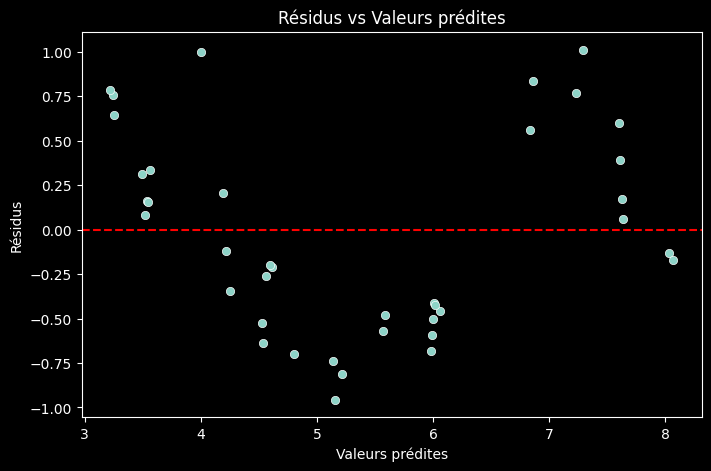

In [18]:
# Résidus
residuals = y_test - y_pred

# Graphique des résidus
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs prédites")
plt.show()

In [19]:
import statsmodels.api as sm
X_test_sm = sm.add_constant(X_test)
bp_test = het_breuschpagan(residuals, X_test_sm)

# Résultats
labels = ['Statistique LM', 'p-value', 'F-statistique', 'p-value F']
print(dict(zip(labels, bp_test)))

{'Statistique LM': 3.014557837290796, 'p-value': 0.3893860856182448, 'F-statistique': 0.9773352589649403, 'p-value F': 0.4145042612624642}


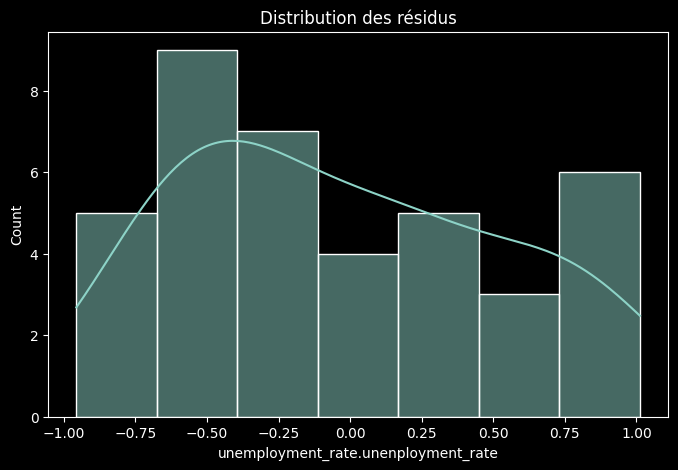

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribution des résidus")
plt.show()

In [21]:
X_vif = sm.add_constant(X)  # Ajout de la constante
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X.columns))]

print(vif_data)

                       Variable       VIF
0                          year  5.341388
1                         month  1.001763
2  unemployment_rate.population  5.337318


In [22]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

MSE: 0.304898695907041
R²: 0.8816690269514406


In [23]:
def linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()

    model.fit(X_train, y_train)

    print("Intercept: ", model.intercept_)
    print("Coefficients:")
    print(list(zip(X.columns, model.coef_)))

    y_pred = model.predict(X_test)

    meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
    meanSqErr = metrics.mean_squared_error(y_test, y_pred)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    print('R^2: {:.2f}'.format(r2_score(y_test, y_pred)))

    #Mean Absolute Error is the absolute difference between the true values and the predicted values.
    #The lower the value, the better is the model’s performance.
    print('Mean Absolute Error:', meanAbErr)

    #Mean Square Error is calculated by taking the average of the square of the difference between the original and predicted values of the data.
    #The lower the value, the better is the model’s performance.
    print('Mean Square Error:', meanSqErr)

    #Root Mean Square Error is the standard deviation of the errors which occur when a prediction is made on a dataset. 
    #The root of the value is considered while determining the accuracy of the model.
    print('Root Mean Square Error:', rootMeanSqErr)
    
    return {'model': model, 'y_test': y_test, 'y_pred': y_pred}

In [24]:
linear_regression(X, y)

Intercept:  259.11665837050043
Coefficients:
[('year', -0.10444455403082605), ('month', -0.009424240917334403), ('unemployment_rate.population', -0.6541679824453834)]
R^2: 0.88
Mean Absolute Error: 0.4813065295848051
Mean Square Error: 0.304898695907041
Root Mean Square Error: 0.5521763268259886


{'model': LinearRegression(),
 'y_test': 152    3.9
 75     5.1
 158    3.6
 66     5.6
 60     5.6
 15     7.7
 9      7.9
 16     7.8
 128    4.1
 125    3.9
 139    5.0
 156    3.7
 18     8.0
 161    3.8
 112    3.9
 181    4.4
 155    3.7
 65     5.6
 165    4.0
 42     7.7
 30     8.0
 24     8.3
 67     5.5
 98     4.4
 69     5.3
 113    4.0
 96     4.2
 19     8.2
 45     7.4
 76     5.0
 169    4.0
 68     5.4
 5      7.9
 132    4.4
 90     4.4
 164    3.9
 108    4.1
 182    4.4
 186    4.3
 Name: unemployment_rate.unenployment_rate, dtype: float64,
 'y_pred': array([3.56487411, 5.58203667, 3.5177529 , 6.01145922, 6.05858042,
        7.63867164, 8.03327978, 7.6292474 , 4.219374  , 4.24764672,
        4.00294433, 3.53660139, 7.61039892, 3.48948018, 4.53525831,
        4.60949324, 3.54602563, 6.02088346, 3.24455412, 6.86509207,
        7.23120381, 7.28774926, 6.00203497, 5.13764844, 5.98318649,
        4.52583407, 5.15649692, 7.60097468, 6.83681934, 5.57261243,
        3.2162

Intercept:  246472.08079173107
Coefficients:
[('gov_total_expense_revenue.expense', 8.45500722639139), ('gov_total_expense_revenue.revenue', 11.736450969087896), ('year', -127.78173894638795), ('month', 49.972036400222606), ('day', -12.291747305326428)]
R^2: 0.97
Mean Absolute Error: 353.75056184157705
Mean Square Error: 206025.30007410867
Root Mean Square Error: 453.90009922240455


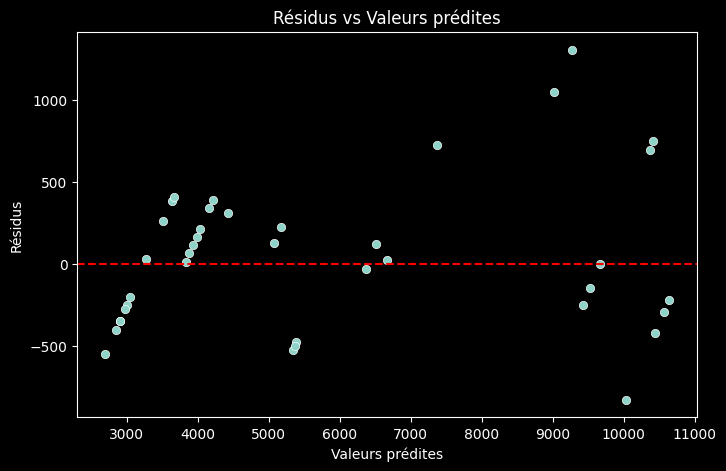

Intercept:  -99942.3828387725
Coefficients:
[('gov_total_expense_revenue.expense', -2.603385103405562), ('gov_total_expense_revenue.revenue', 2.207250375092841), ('year', 51.94440220519304), ('month', 2.374918360436111), ('day', 0.5649976560417413)]
R^2: 0.42
Mean Absolute Error: 115.11440046609746
Mean Square Error: 27363.69342442448
Root Mean Square Error: 165.4197491970789


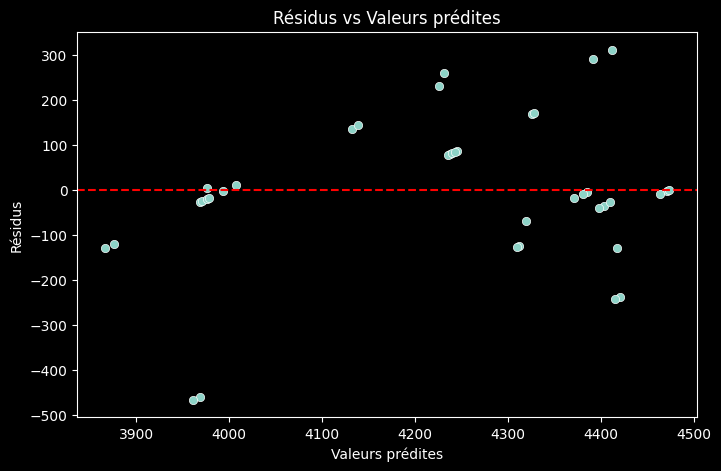

Intercept:  307123.2639582515
Coefficients:
[('gov_total_expense_revenue.expense', 3.30954152793788), ('gov_total_expense_revenue.revenue', 1.9424269064138728), ('year', -150.87434147060713), ('month', 2.0529653004043293), ('day', -2.4601862427025605)]
R^2: 0.76
Mean Absolute Error: 126.20548500992113
Mean Square Error: 31302.272919381074
Root Mean Square Error: 176.92448366289238


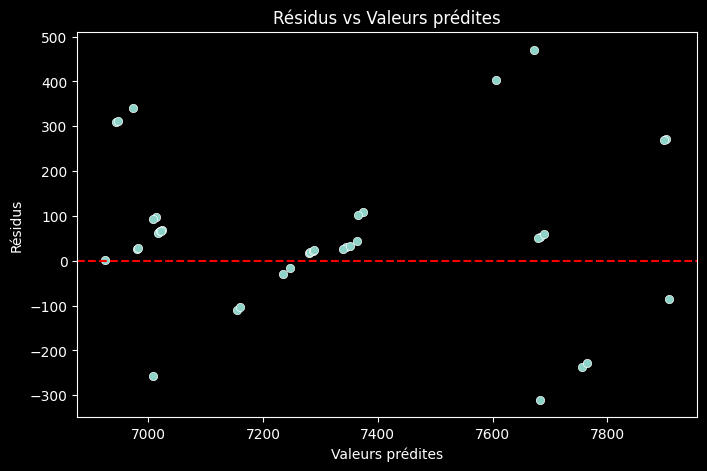

Intercept:  8422272.539836498
Coefficients:
[('gov_total_expense_revenue.expense', 33.07946389035623), ('gov_total_expense_revenue.revenue', 101.70993581305598), ('year', -4203.146852683545), ('month', 95.0142406300449), ('day', 8.833227505905352)]
R^2: 0.43
Mean Absolute Error: 4180.987174285719
Mean Square Error: 27422091.047209647
Root Mean Square Error: 5236.610644988765


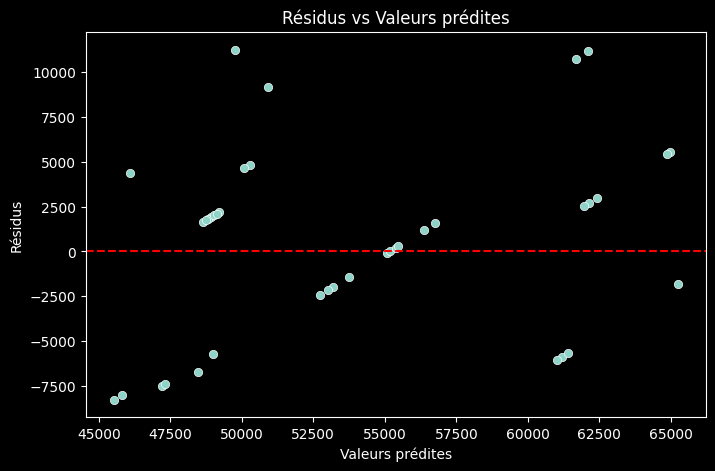

Intercept:  108259314.185132
Coefficients:
[('gov_total_expense_revenue.expense', 310.1646207407178), ('gov_total_expense_revenue.revenue', 2430.4576516130173), ('year', -54281.186090869574), ('month', 3452.658394649346), ('day', -458.01365026589855)]
R^2: 0.83
Mean Absolute Error: 69412.26737217185
Mean Square Error: 8227046881.615481
Root Mean Square Error: 90703.06985772577


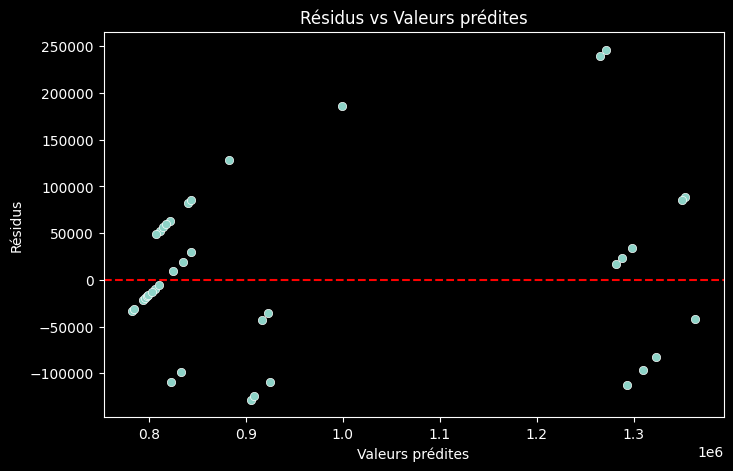

Intercept:  66000.75472898797
Coefficients:
[('gov_total_expense_revenue.expense', 2.060245026224499), ('gov_total_expense_revenue.revenue', 8.538454044154118), ('year', -35.82011901757203), ('month', 28.76976165641155), ('day', -4.093942180113926)]
R^2: 0.87
Mean Absolute Error: 495.98548016511575
Mean Square Error: 323943.1862174975
Root Mean Square Error: 569.1600708214671


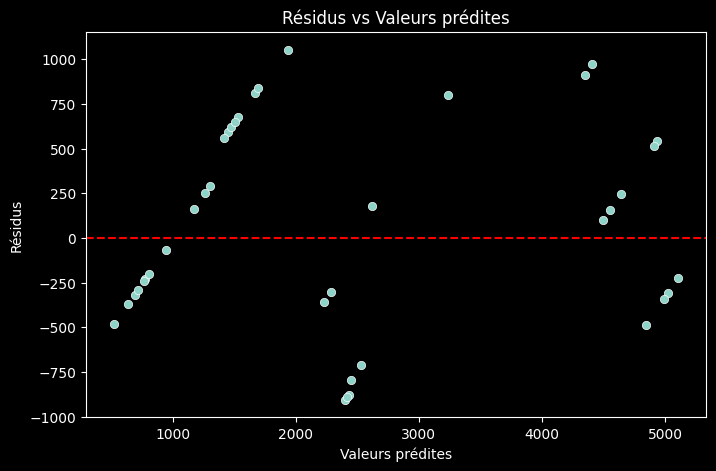

Intercept:  278457580.5937613
Coefficients:
[('gov_total_expense_revenue.expense', 1223.3012094990943), ('gov_total_expense_revenue.revenue', 6738.70711800834), ('year', -139994.75701252316), ('month', 11501.78052244842), ('day', -1180.9050365703795)]
R^2: 0.88
Mean Absolute Error: 190973.83360165052
Mean Square Error: 63009209429.95023
Root Mean Square Error: 251016.35291341128


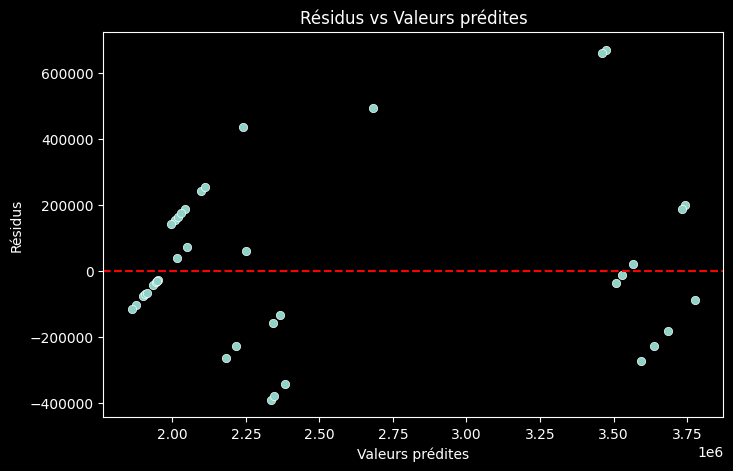

Intercept:  197879.98072925498
Coefficients:
[('gov_total_expense_revenue.expense', 4.3484971866690705), ('gov_total_expense_revenue.revenue', 9.420941195430547), ('year', -98.61354123851471), ('month', 36.25706061906085), ('day', -7.6744021386791585)]
R^2: 0.91
Mean Absolute Error: 419.38531532964913
Mean Square Error: 281819.0655809077
Root Mean Square Error: 530.866334947798


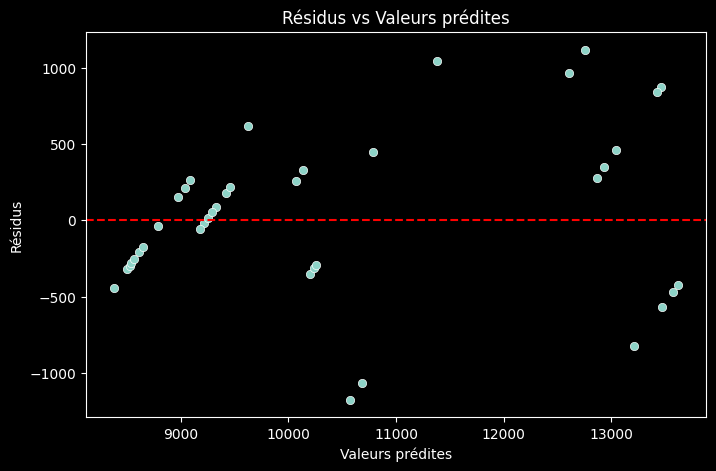

Intercept:  30894.49233800927
Coefficients:
[('gov_total_expense_revenue.expense', 0.0070038050250136406), ('gov_total_expense_revenue.revenue', 0.4995208373258148), ('year', -15.320294179068867), ('month', 0.25128226959563255), ('day', -0.05409019979496211)]
R^2: 0.55
Mean Absolute Error: 17.822190665751098
Mean Square Error: 534.2945835941331
Root Mean Square Error: 23.114813077205124


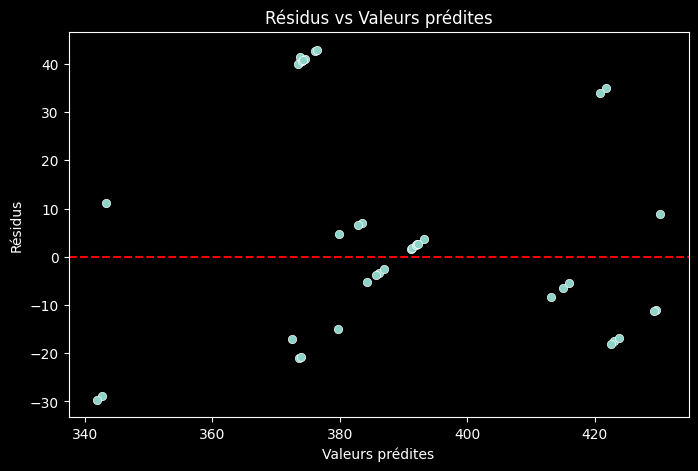

Intercept:  1632687.9144932108
Coefficients:
[('gov_total_expense_revenue.expense', 3.78055458647351), ('gov_total_expense_revenue.revenue', 12.300538449709046), ('year', -813.0668915183112), ('month', -18.92630413600008), ('day', 1.1263015604820092)]
R^2: 0.75
Mean Absolute Error: 588.3723094643154
Mean Square Error: 447380.7963638198
Root Mean Square Error: 668.8653050979844


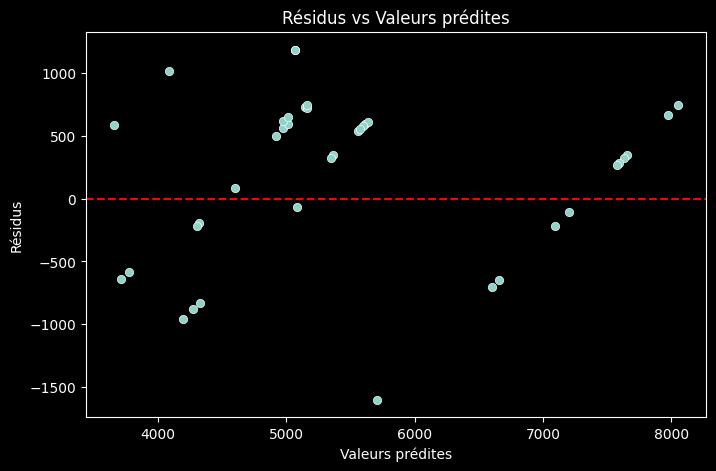

In [25]:
for name in xlsx['company_revenue'].columns[1:]:
    y = df_final[name]

    L = list(xlsx['gov_total_expense_revenue'].columns)
    L.append('year')
    L.append('month')
    L.append('day')


    X = df_final[L]
    X = X.drop('date', axis=1)
    X = X.drop('gov_total_expense_revenue.surplus_or_deficit', axis=1)

    test = linear_regression(X, y)

    # Résidus
    residuals = test['y_pred'] - test['y_test']


    # Graphique des résidus

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=test['y_pred'], y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.title("Résidus vs Valeurs prédites")
    plt.show()

In [26]:
import statsmodels.formula.api as smf
def run_regression(df, dependent_var, independent_vars, independent_file):
    # Suppression du préfixe pour la variable dépendante
    dep_var_clean = dependent_var.split('.')[-1]


    X = df[[f"{independent_file}.{var}" for var in independent_vars[1:]]]

    # Ajout de la colonne 'year' qui n'a pas de préfixe
    X.loc[:, 'year'] = df[independent_vars[0]]

    new_col_names = [col.split('.')[-1] for col in independent_vars]
    X.columns = new_col_names

    # Extraction de la variable dépendante
    y = df[dependent_var]

    # Fusion des données
    df_model = X.join(y)
    df_model.columns = new_col_names + [dep_var_clean]

    # Construction de la formule de régression
    formula = f"{dep_var_clean} ~ {' + '.join(new_col_names)}"

    # Modélisation
    model = smf.ols(formula=formula, data=df_model).fit()

    return model.summary()

In [27]:
result = run_regression(
    df=df_final,
    dependent_var='company_revenue.speedy_hire_plc_sdy_l',
    independent_vars=['year', 'gbp_to_usd_exchange_rate', 'economic_growth_rate'],
    independent_file='economic_growth'
)

result

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     speedy_hire_plc_sdy_l   R-squared:                       0.106
Model:                               OLS   Adj. R-squared:                  0.091
Method:                    Least Squares   F-statistic:                     7.356
Date:                   Sun, 09 Feb 2025   Prob (F-statistic):           0.000110
Time:                           20:47:17   Log-Likelihood:                -895.20
No. Observations:                    191   AIC:                             1798.
Df Residuals:                        187   BIC:                             1811.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2963.5306   1676.134     -1.768      0.079   -6270.093     343.032
year                        -5.9561     23.756     -0.251      0.802     -52.821      40.909
gbp_to_usd_exchange_rate     0.7896      0.346      2.281      0.024       0.107       1.472
economic_growth_rate         1.6640      0.817      2.037      0.043       0.052       3.276
==============================================================================
Omnibus:                       14.868   Durbin-Watson:                   0.112
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.276
Skew:                          -0.709   Prob(JB):                     0.000292
Kurtosis:                       3.189   Cond. No.                     1.76e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
X = list(xlsx['unemployment_rate'].columns[1:]) 
X += list(xlsx['extra_unemployment_rate'].columns[3:5])
X.append(xlsx['gov_total_expense_revenue'].columns[3])
X += list(xlsx['money_supply'].columns[1:])
X += list(xlsx['bonds'].columns[1:])
X += list(xlsx['cpi'].columns[1:])
X += list(xlsx['economic_growth'].columns[1:])
X += list(xlsx['import_export'].columns[1:])
X += list(xlsx['seasonal_retail_sales'].columns[1:])
#X += list(xlsx['uk_home_retail'].columns[1:]) too many columns
X += list(xlsx['uk_building'].columns[1:])
#X += list(xlsx['uk_affordability_index'].columns[1:]) too many columns
X += list(xlsx['uk_retail_price'].columns[1:])
X += list(xlsx['mortage'].columns[1:])
X += list(xlsx['mortage_interest_rate'].columns[1:])
X.append(xlsx['construction_cost_prices_sales'].columns[1])
X += list(xlsx['construction_cost_prices_sales'].columns[3:5])
X += list(xlsx['construction_cost_prices_sales'].columns[6:])
X.append('year')

In [29]:
def regression_analysis(df, dependent_var, independent_vars, show_feature_importance=False, n_splits=5, save_results=True, results_path='results.pkl'):
    results = []
    feature_importance_results = {}
    best_models = {}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X = df[independent_vars].copy()
    y = df[dependent_var].copy()

    # Test de normalité
    p_values = [shapiro(X[col])[1] for col in X.columns]
    normality_verified = all(p > 0.05 for p in p_values)

    scaler = StandardScaler() if normality_verified else MinMaxScaler()
    print(f"Data for {dependent_var} is standardized" if normality_verified else f"Data for {dependent_var} is normalized")

    model_results = []
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Support Vector Regressor': SVR(),
        'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
    }

    for k in range(3, 11):
        models[f'KNN (k={k})'] = KNeighborsRegressor(n_neighbors=k)

    for model_name, model in models.items():
        mae_train_scores, mae_test_scores, r2_scores = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)

            mae_train_scores.append(mean_absolute_error(y_train, y_pred_train))
            mae_test_scores.append(mean_absolute_error(y_test, y_pred_test))
            r2_scores.append(r2_score(y_test, y_pred_test))

        avg_mae_train = np.mean(mae_train_scores)
        avg_mae_test = np.mean(mae_test_scores)
        avg_r2 = np.mean(r2_scores)

        if hasattr(model, "coef_"):
            importance = model.coef_.flatten()
            feature_names = independent_vars
        elif hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
            feature_names = independent_vars
        else:
            perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
            importance = perm_importance.importances_mean
            feature_names = X.columns

        if len(importance) == len(feature_names):
            feature_importance_results[model_name] = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        else:
            print(f"⚠️ Dimension mismatch for {model_name}: {len(importance)} importances vs {len(feature_names)} features")
            feature_importance_results[model_name] = pd.Series(importance[:len(feature_names)], index=feature_names).sort_values(ascending=False)

        model_results.append({
            "Model": model_name,
            'MAE Train': avg_mae_train,
            'MAE Test': avg_mae_test,
            'R² Test': avg_r2
        })

    best_model = min(model_results, key=lambda x: (x['MAE Test'], -x['R² Test']))
    best_models[dependent_var] = {
        'Model': best_model['Model'],
        'Performance': best_model,
        'Top Features': feature_importance_results[best_model['Model']].head(10)
    }

    results.extend(model_results)

    if save_results:
        with open(results_path, 'wb') as f:
            pickle.dump({'results': results, 'best_models': best_models}, f)

    if show_feature_importance:
        for model, importance in feature_importance_results.items():
            print(f"\nFeature Importance for {model}:")
            print(importance.head(10))

    results_df = pd.DataFrame(results)
    return results_df, best_models


In [30]:
def plot_metrics(results, best_models, dependent_var):
    d = {i: list(best_models.keys())[i] for i in range(len(results))}
    d = {value: key for key, value in d.items()}

    # Filtrer les résultats pour la variable dépendante spécifique
    subset = results[d[dependent_var]]

    # MAE Plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35  # Largeur des barres
    models = subset['Model'].unique()

    mae_train = subset['MAE Train']
    mae_test = subset['MAE Test']
    indices = range(len(models))
    
    plt.bar(indices, mae_train, bar_width, label='MAE Train', color='skyblue')
    plt.bar([i + bar_width for i in indices], mae_test, bar_width, label='MAE Test', color='orange')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'MAE Train vs Test for {dependent_var}')
    plt.xticks([i + bar_width / 2 for i in indices], models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # R² Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='R² Test', data=subset, palette='viridis')
    plt.title(f'R² Test for {dependent_var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [31]:
def plot_models(best_models):
    # Transformation des données en DataFrame
    data = []
    for dependent_var, models in best_models.items():
        d = models['Performance']
        data.append({
                'Variable Dépendante': dependent_var,
                'Modèle': d['Model'],
                'MAE Train': d['MAE Train'],
                'MAE Test': d['MAE Test'],
                'R² Test': d['R² Test']
            })

    df = pd.DataFrame(data)

    # Reshape des données pour le MAE (Train & Test) côte à côte
    df_melted = pd.melt(df, 
                        id_vars=['Variable Dépendante', 'Modèle'], 
                        value_vars=['MAE Train', 'MAE Test'], 
                        var_name='Type de MAE', 
                        value_name='Valeur MAE')

    # --- Plot MAE Train & Test côte à côte ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Variable Dépendante', y='Valeur MAE', hue='Type de MAE', data=df_melted, palette='Set2')

    plt.title('MAE Train vs MAE Test by Dependent Variable')
    plt.xlabel('Dependent Variable')
    plt.ylabel('MAE')
    plt.legend(title='MAE Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot R² Test ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Variable Dépendante', y='R² Test', hue='Modèle', data=df, palette='Set1')

    plt.title('R² Test by Dependent Variable')
    plt.xlabel('Dependent Variable')
    plt.ylabel('R² Test')
    plt.legend(title='ML Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
def plot_feature_importance(best_models):
    feature_importances = pd.Series(dtype='float64')

    for models in best_models.values():
        top_features = models['Top Features']  
        feature_importances = feature_importances.add(top_features, fill_value=0)

    # Étape 3 : Sélection des 10 features les plus importantes
    top_10_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]
    df_top_features = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])

    # Étape 4 : Diagramme en barres
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=df_top_features, palette='coolwarm')

    plt.title('Top 10 Most Important Features')
    plt.xlabel('Summed importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

## Revenues prediction

In [33]:
dependent_vars_revenue = list(df_final[xlsx['company_revenue'].columns[1:]])
df = df_final[dependent_vars_revenue + X].copy()

In [34]:
revenue_results = []
for i in dependent_vars_revenue:
    revenue_results.append(regression_analysis(df, i, X))

Data for company_revenue.ashtead_group_plc_aht_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.babcock_international_group_plc_bab_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.column1 is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for company_revenue.caterpillar_inc_cat is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mis

In [35]:
revenue_results_dict = []
for i in range(len(revenue_results)):
    revenue_results_dict.append(revenue_results[i][0])

best_models_revenue = []
for i in range(len(revenue_results)):
    best_models_revenue.append(revenue_results[i][1])

best_models_revenue = {list(item.keys())[0]: item[list(item.keys())[0]] for item in best_models_revenue}

dict_keys(['company_revenue.ashtead_group_plc_aht_l', 'company_revenue.babcock_international_group_plc_bab_l', 'company_revenue.column1', 'company_revenue.caterpillar_inc_cat', 'company_revenue.hitachi_construction_machinery_co_ltd_6305_t', 'company_revenue.j_c_bamford_excavators_ltd_4296370337', 'company_revenue.komatsu_ltd_6301_t', 'company_revenue.liebherr_international_ltd_4298321885', 'company_revenue.speedy_hire_plc_sdy_l', 'company_revenue.terex_corp_tex'])


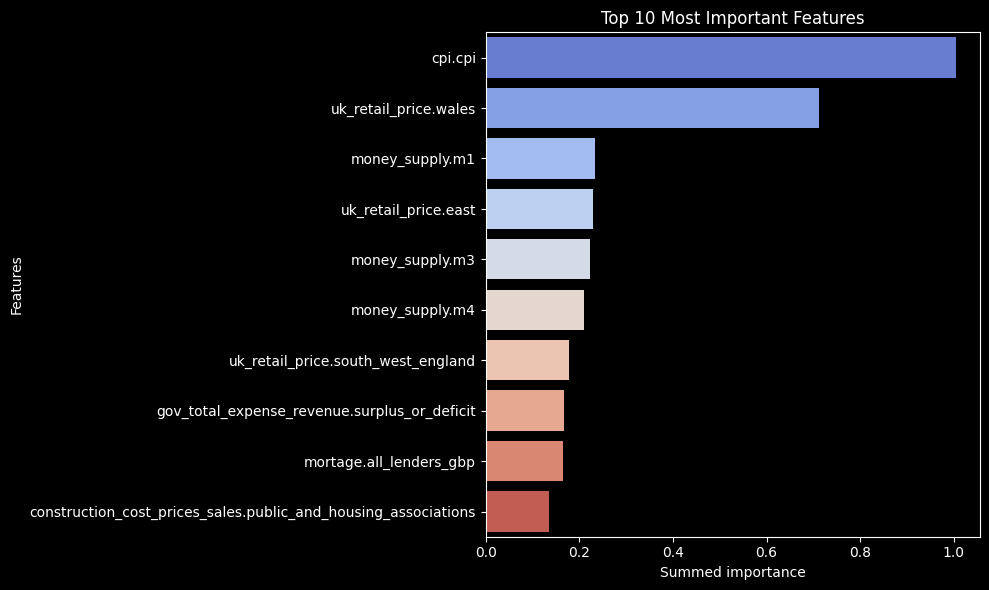

In [46]:
plot_feature_importance(best_models_revenue)

In [ ]:
for i in dependent_vars_revenue:
    plot_metrics(revenue_results_dict, best_models_revenue, i)

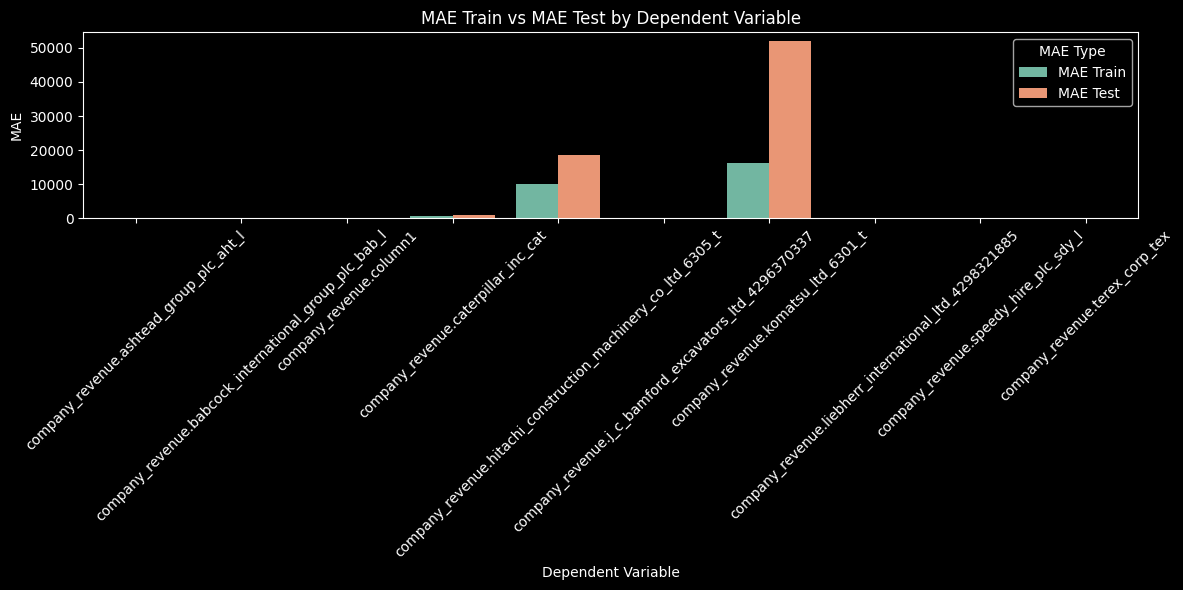

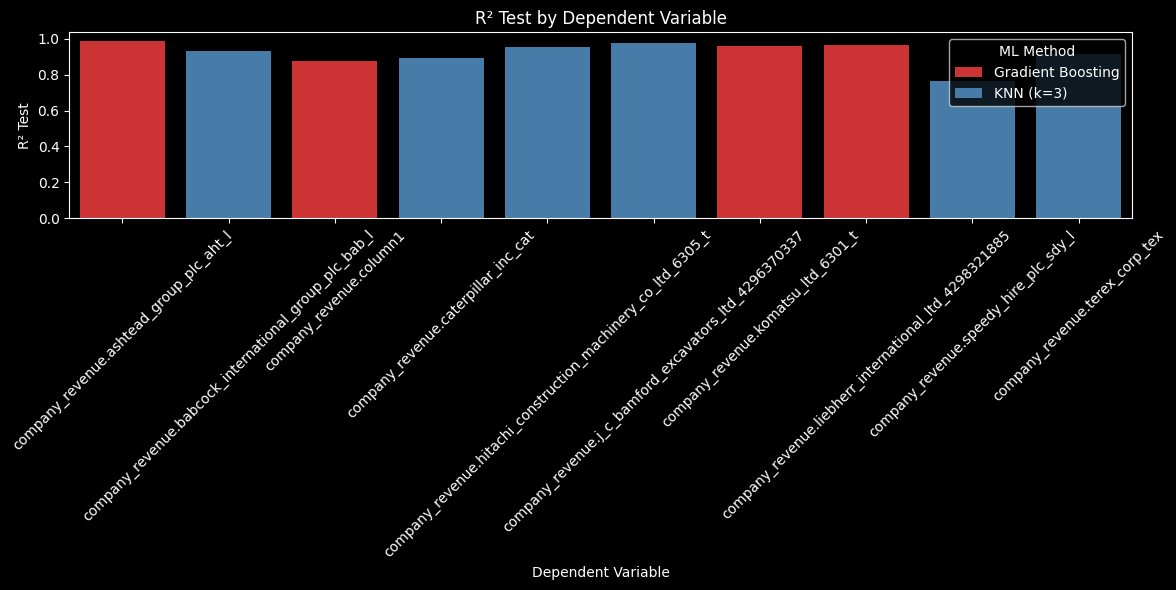

In [38]:
plot_models(best_models_revenue)

## Cost prediction

In [40]:
dependent_vars_cost = list(df_final[xlsx['operating_expenses'].columns[1:]])
df = df_final[dependent_vars_cost + X].copy()

In [41]:
cost_results = []
for i in dependent_vars_cost:
    cost_results.append(regression_analysis(df, i, X))

Data for operating_expenses.ashtead_group_plc_aht_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.babcock_international_group_plc_bab_l is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.column1 is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ Dimension mismatch for Random Forest: 83 importances vs 77 features
⚠️ Dimension mismatch for Gradient Boosting: 83 importances vs 77 features
Data for operating_expenses.caterpillar_inc_cat is normalized
⚠️ Dimension mismatch for Linear Regression: 83 importances vs 77 features
⚠️ D

In [42]:
cost_results_dict = []
for i in range(len(cost_results)):
    cost_results_dict.append(cost_results[i][0])

best_models_cost = []
for i in range(len(cost_results)):
    best_models_cost.append(cost_results[i][1])

best_models_cost = {list(item.keys())[0]: item[list(item.keys())[0]] for item in best_models_cost}

In [ ]:
for i in dependent_vars_cost:
    plot_metrics(cost_results_dict, best_models_cost, i)

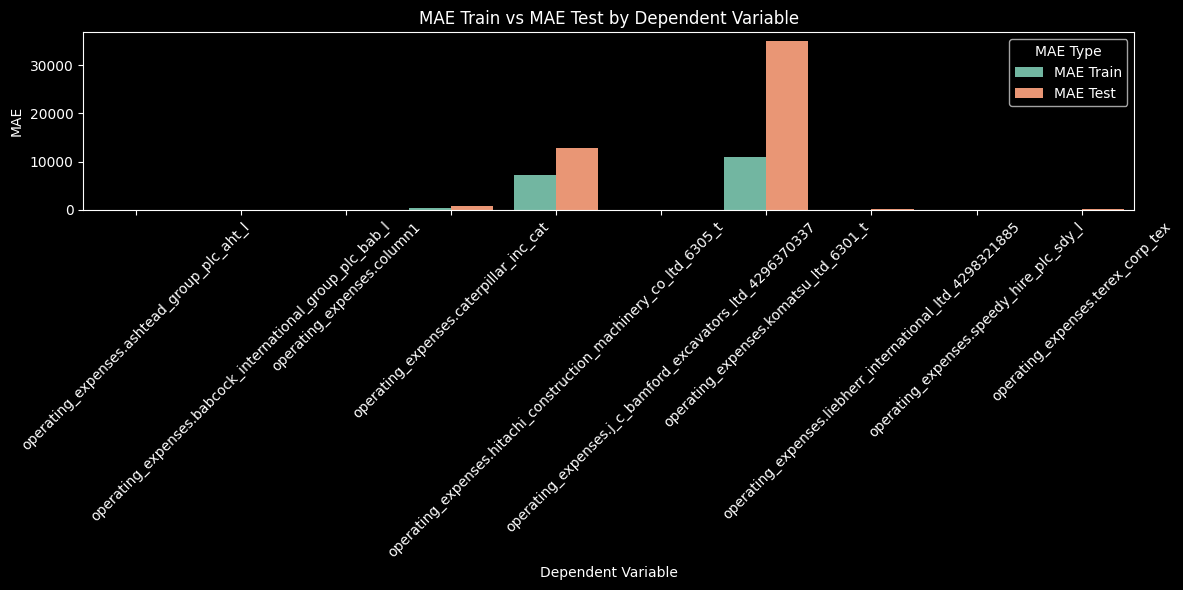

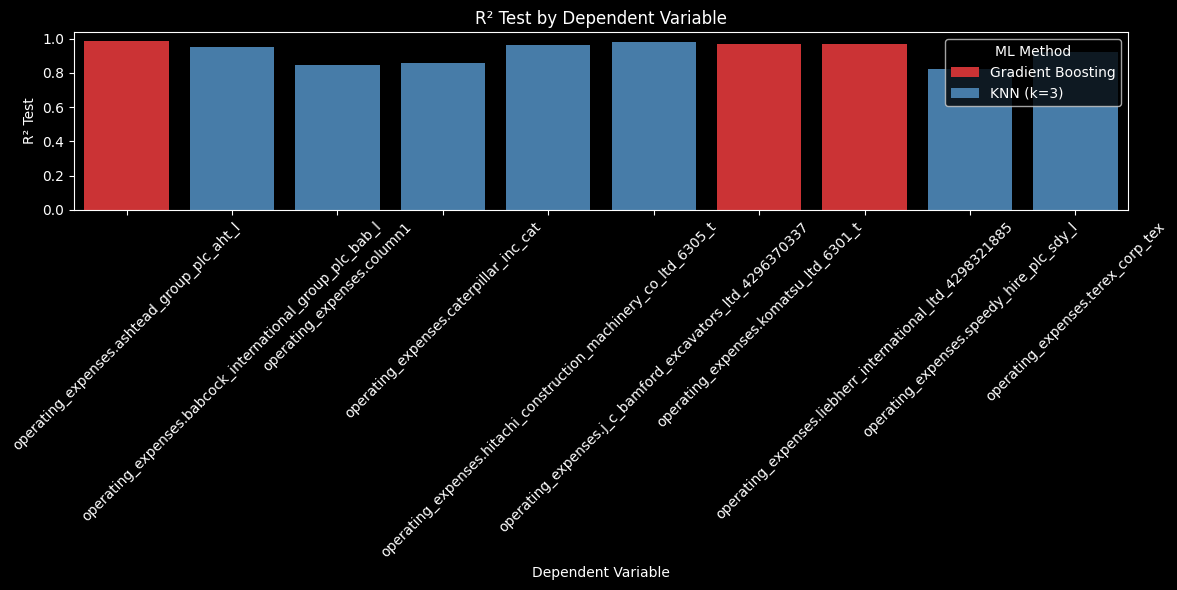

In [44]:
plot_models(best_models_cost)

dict_keys(['operating_expenses.ashtead_group_plc_aht_l', 'operating_expenses.babcock_international_group_plc_bab_l', 'operating_expenses.column1', 'operating_expenses.caterpillar_inc_cat', 'operating_expenses.hitachi_construction_machinery_co_ltd_6305_t', 'operating_expenses.j_c_bamford_excavators_ltd_4296370337', 'operating_expenses.komatsu_ltd_6301_t', 'operating_expenses.liebherr_international_ltd_4298321885', 'operating_expenses.speedy_hire_plc_sdy_l', 'operating_expenses.terex_corp_tex'])


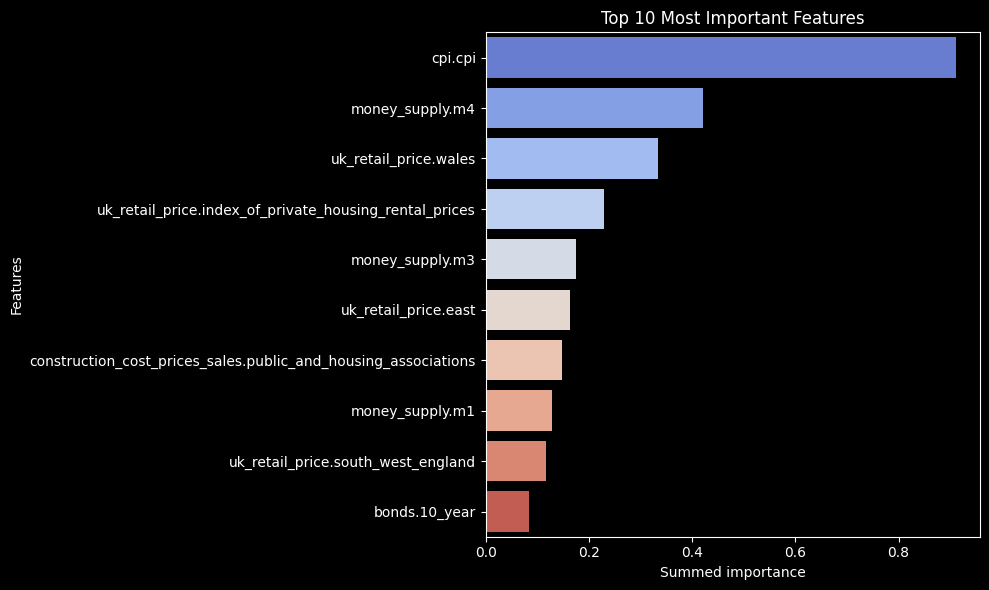

In [45]:
plot_feature_importance(best_models_cost)